# Sarcasm Detection with Stance Detection - Sementic NLP

NLP Project

# Installation of all the libraries which we will be using

For this approach we have used GloVe + LSTM approach for Sarcasm Detection

For Stance detection we have used Udacity online model

In [17]:
import numpy as np 
import pandas as pd 
import os
import re
import matplotlib.pyplot as plt
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, GRU, LSTM, Bidirectional
from keras.layers.embeddings import Embedding
from keras.initializers import Constant
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

# Download dataset from kaggle

1. Login to your Kaggle Account

2. Go to the account settings

3. Scroll a bit and click on 'Create New API token'
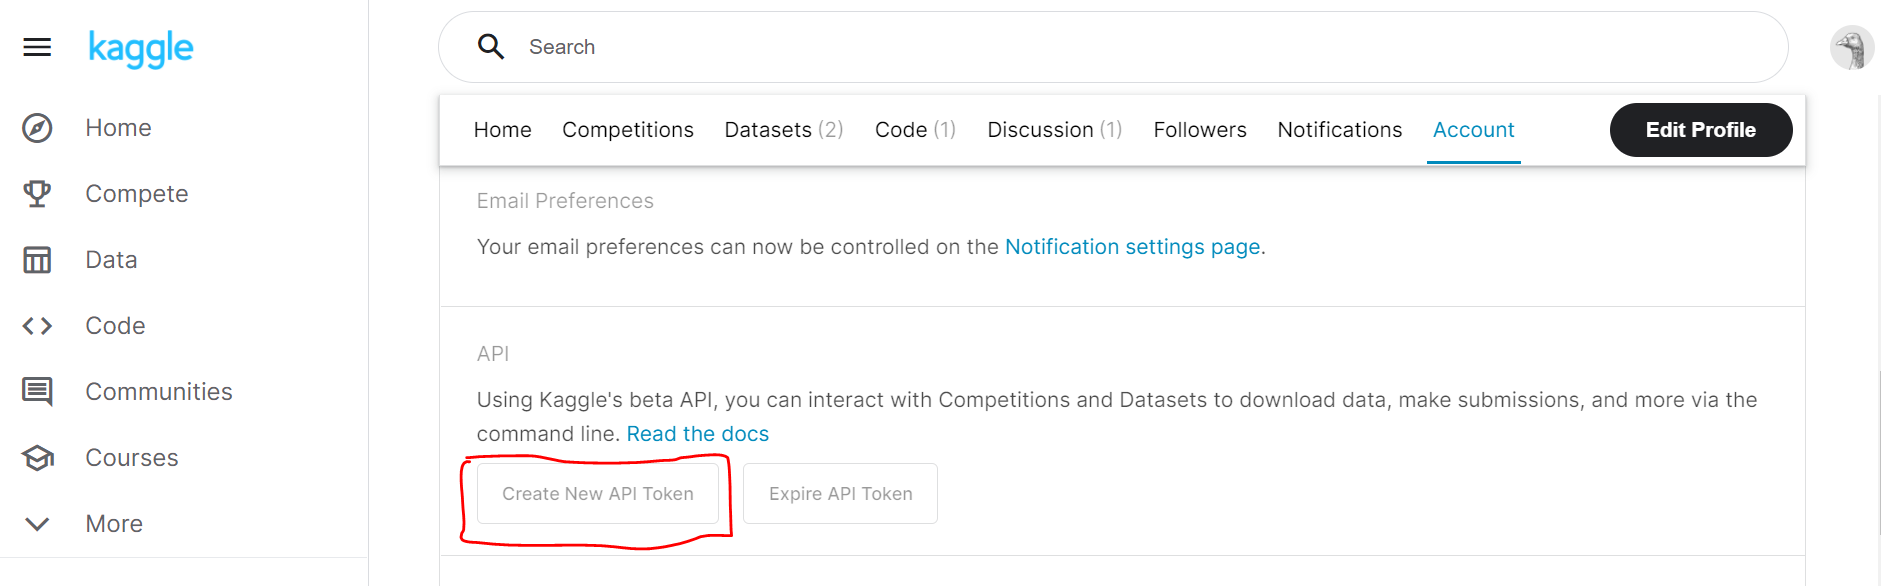
4. Kaggle.json file will be downloaded which you have to upload below

5. After that Kaggle dataset will be downloaded

In [18]:
! mkdir data

In [19]:
! pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

In [24]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [25]:
! cp kaggle.json ~/.kaggle/

In [26]:
! chmod 600 ~/.kaggle/kaggle.json

In [27]:
! kaggle datasets list

ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              227KB  2021-05-08 09:30:51           4734  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-04-28 17:03:01           2712  
mathurinache/twitter-edge-nodes                             Twitter Edge Nodes                                342MB  2021-03-08 06:43:04            293  
promptcloud/careerbuilder-job-listing-2020                  Careerbuilder Job Listing 2020                     42MB  2021-03-05 06:59:52            668  
dhruvildave/wikibooks-dataset                               Wikibooks Datase

In [28]:
! kaggle datasets download -d rmisra/news-headlines-dataset-for-sarcasm-detection

  0% 0.00/3.30M [00:00<?, ?B/s]
100% 3.30M/3.30M [00:00<00:00, 112MB/s]


In [29]:
! unzip news-headlines-dataset-for-sarcasm-detection -d data/

Archive:  news-headlines-dataset-for-sarcasm-detection.zip
  inflating: data/Sarcasm_Headlines_Dataset.json  
  inflating: data/Sarcasm_Headlines_Dataset_v2.json  


In [30]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

data_1 = pd.read_json('data/Sarcasm_Headlines_Dataset.json', lines=True)
data_2 = pd.read_json('data/Sarcasm_Headlines_Dataset_v2.json', lines=True)
sarcasm_data =  pd.concat([data_1, data_2])
sarcasm_data.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [31]:
len(sarcasm_data)

55328

# Data cleaning

In [32]:
def clean_text(text):
    text = text.lower()
    #This will remove the links from the dataset
    pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    text = pattern.sub('', text)
    text = " ".join(filter(lambda x:x[0]!='@', text.split()))
    #This will remove the emoticons from the data
    emoji = re.compile("["
                           u"\U0001F600-\U0001FFFF"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    
    text = emoji.sub(r'', text)
    #Converting everything in lowercase
    text = text.lower()

    #Switching every abbreviation with fullforms
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"that's", "that is", text)        
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"where's", "where is", text) 
    text = re.sub(r"\'ll", " will", text)  
    text = re.sub(r"\'ve", " have", text)  
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"did't", "did not", text)
    text = re.sub(r"can't", "can not", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"couldn't", "could not", text)
    text = re.sub(r"have't", "have not", text)
    #Removing punctuation and symbols
    text = re.sub(r"[,.\"\'!@#$%^&*(){}?/;`~:<>+=-]", "", text)
    return text

In [33]:
import string
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

def CleanTokenize(df):
  
    head_lines = list()
    lines = df["headline"].values.tolist()

    for line in lines:
        line = clean_text(line)
        # tokenize the text
        tokens = word_tokenize(line)
        # remove puntuations
        table = str.maketrans('', '', string.punctuation)
        stripped = [w.translate(table) for w in tokens]
        # remove non alphabetic characters
        words = [word for word in stripped if word.isalpha()]
        stop_words = set(stopwords.words("english"))
        # remove stop words
        words = [w for w in words if not w in stop_words]
        head_lines.append(words)
    return head_lines

head_lines = CleanTokenize(sarcasm_data)
head_lines[0:20]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


[['former',
  'versace',
  'store',
  'clerk',
  'sues',
  'secret',
  'black',
  'code',
  'minority',
  'shoppers'],
 ['roseanne',
  'revival',
  'catches',
  'thorny',
  'political',
  'mood',
  'better',
  'worse'],
 ['mom',
  'starting',
  'fear',
  'sons',
  'web',
  'series',
  'closest',
  'thing',
  'grandchild'],
 ['boehner',
  'wants',
  'wife',
  'listen',
  'come',
  'alternative',
  'debtreduction',
  'ideas'],
 ['jk', 'rowling', 'wishes', 'snape', 'happy', 'birthday', 'magical', 'way'],
 ['advancing', 'worlds', 'women'],
 ['fascinating', 'case', 'eating', 'labgrown', 'meat'],
 ['ceo', 'send', 'kids', 'school', 'work', 'company'],
 ['top', 'snake', 'handler', 'leaves', 'sinking', 'huckabee', 'campaign'],
 ['fridays', 'morning', 'email', 'inside', 'trumps', 'presser', 'ages'],
 ['airline',
  'passengers',
  'tackle',
  'man',
  'rushes',
  'cockpit',
  'bomb',
  'threat'],
 ['facebook', 'reportedly', 'working', 'healthcare', 'features', 'apps'],
 ['north',
  'korea',
  'pr

# Lets visualize word cloud for sarcastic and non-sarcastic words

(-0.5, 999.5, 499.5, -0.5)

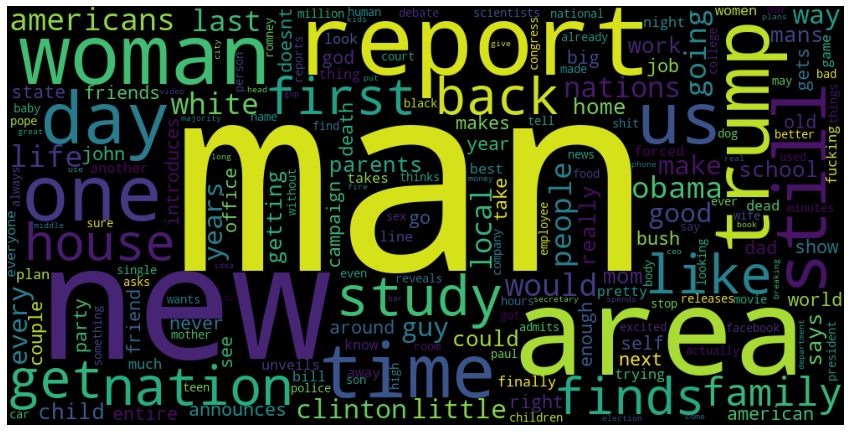

In [34]:
#Word cloud based on the frequency of the words

from collections import Counter
from wordcloud import WordCloud, ImageColorGenerator

#Word cloud for sarcastic
pos_data = sarcasm_data.loc[sarcasm_data['is_sarcastic'] == 1]
pos_head_lines = CleanTokenize(pos_data)
pos_lines = [j for sub in pos_head_lines for j in sub] 
word_could_dict=Counter(pos_lines)

wordcloud = WordCloud(background_color="black",width = 1000, height = 500).generate_from_frequencies(word_could_dict)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")

(-0.5, 999.5, 499.5, -0.5)

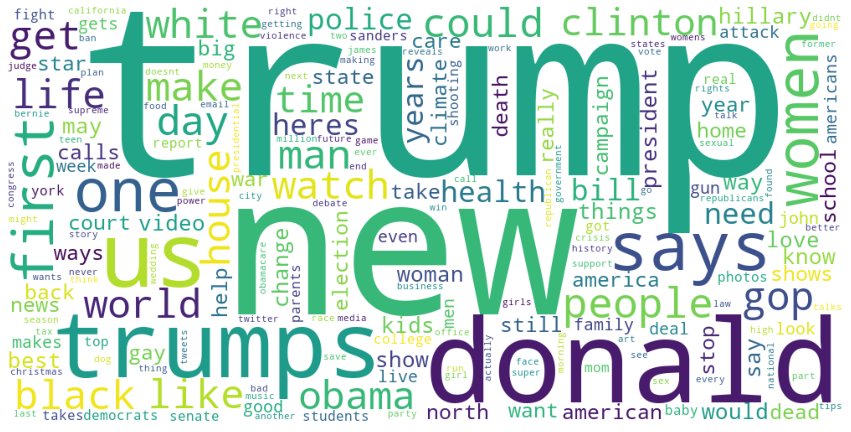

In [35]:
from collections import Counter
from wordcloud import WordCloud, ImageColorGenerator

#Word cloud for non-sarcastic 
pos_data = sarcasm_data.loc[sarcasm_data['is_sarcastic'] == 0]
pos_head_lines = CleanTokenize(pos_data)
pos_lines = [j for sub in pos_head_lines for j in sub] 
word_could_dict=Counter(pos_lines)

wordcloud = WordCloud(background_color="white", width = 1000, height = 500).generate_from_frequencies(word_could_dict)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")

# Train and Test split

In [36]:

validation_split = 0.2
max_length = 25


tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(head_lines)
sequences = tokenizer_obj.texts_to_sequences(head_lines)

word_index = tokenizer_obj.word_index
print("unique tokens - ",len(word_index))
#+1 for unique words that are not present in the vocabulary
vocab_size = len(tokenizer_obj.word_index) + 1
print('vocab size -', vocab_size)

#Adding padding to those headlines whose lengths are not 25 and also it will cut those words
#that comes after 25
lines_pad = pad_sequences(sequences, maxlen=max_length, padding='post')
sentiment =  sarcasm_data['is_sarcastic'].values

indices = np.arange(lines_pad.shape[0])
#shuffling
np.random.shuffle(indices)
lines_pad = lines_pad[indices]
sentiment = sentiment[indices]

num_validation_samples = int(validation_split * lines_pad.shape[0])

X_train_pad = lines_pad[:-num_validation_samples]
y_train = sentiment[:-num_validation_samples]
X_test_pad = lines_pad[-num_validation_samples:]
y_test = sentiment[-num_validation_samples:]

unique tokens -  28657
vocab size - 28658


In [37]:
print('Shape of X_train_pad:', X_train_pad.shape)
print('Shape of y_train:', y_train.shape)

print('Shape of X_test_pad:', X_test_pad.shape)
print('Shape of y_test:', y_test.shape)

Shape of X_train_pad: (44263, 25)
Shape of y_train: (44263,)
Shape of X_test_pad: (11065, 25)
Shape of y_test: (11065,)


https://nlp.stanford.edu/projects/glove/

# Download GloVe model 

In [38]:
!wget http://nlp.stanford.edu/data/glove.twitter.27B.zip

--2021-05-11 15:26:38--  http://nlp.stanford.edu/data/glove.twitter.27B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.twitter.27B.zip [following]
--2021-05-11 15:26:38--  https://nlp.stanford.edu/data/glove.twitter.27B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip [following]
--2021-05-11 15:26:39--  http://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1520408563 (1.4G) [appli

In [39]:
!mkdir Glove

In [40]:
!unzip glove.twitter.27B.zip -d Glove/

Archive:  glove.twitter.27B.zip
  inflating: Glove/glove.twitter.27B.25d.txt  
  inflating: Glove/glove.twitter.27B.50d.txt  
  inflating: Glove/glove.twitter.27B.100d.txt  
  inflating: Glove/glove.twitter.27B.200d.txt  


# Embedding Layer

In [41]:
embeddings_index = {}
embedding_dim = 200
GLOVE_DIR = 'Glove'
f = open(os.path.join(GLOVE_DIR, 'glove.twitter.27B.200d.txt'), encoding = "utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 1193514 word vectors.


In [42]:
#Embedding matrix
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
c = 0
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        c+=1
        embedding_matrix[i] = embedding_vector
print(c)

24755


In [43]:
embedding_layer = Embedding(len(word_index) + 1,
                            embedding_dim,
                            weights=[embedding_matrix],
                            input_length=max_length,
                            trainable=False)
#False because we are using the pretrained model

# Long short-term memory (LSTM)

In [44]:
model = Sequential()
model.add(embedding_layer)
#Hyperparameters
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.25))
#As we are dealing with binary classification that is why we need to use sigmoid function
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

print('Summary of the built model...')
print(model.summary())

Summary of the built model...
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 25, 200)           5731600   
_________________________________________________________________
lstm (LSTM)                  (None, 64)                67840     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 5,799,505
Trainable params: 67,905
Non-trainable params: 5,731,600
_________________________________________________________________
None


# Lets train our model :D

In [45]:
history = model.fit(X_train_pad, y_train, batch_size=32, epochs=10, validation_data=(X_test_pad, y_test), verbose=2)

Epoch 1/10
1384/1384 - 59s - loss: 0.4880 - acc: 0.7626 - val_loss: 0.4021 - val_acc: 0.8171
Epoch 2/10
1384/1384 - 51s - loss: 0.3947 - acc: 0.8210 - val_loss: 0.3436 - val_acc: 0.8504
Epoch 3/10
1384/1384 - 51s - loss: 0.3402 - acc: 0.8513 - val_loss: 0.3142 - val_acc: 0.8626
Epoch 4/10
1384/1384 - 52s - loss: 0.2988 - acc: 0.8714 - val_loss: 0.2910 - val_acc: 0.8747
Epoch 5/10
1384/1384 - 51s - loss: 0.2667 - acc: 0.8889 - val_loss: 0.2760 - val_acc: 0.8850
Epoch 6/10
1384/1384 - 52s - loss: 0.2437 - acc: 0.8986 - val_loss: 0.2594 - val_acc: 0.8944
Epoch 7/10
1384/1384 - 52s - loss: 0.2201 - acc: 0.9099 - val_loss: 0.2337 - val_acc: 0.9092
Epoch 8/10
1384/1384 - 52s - loss: 0.2044 - acc: 0.9180 - val_loss: 0.2331 - val_acc: 0.9096
Epoch 9/10
1384/1384 - 52s - loss: 0.1915 - acc: 0.9233 - val_loss: 0.2111 - val_acc: 0.9220
Epoch 10/10
1384/1384 - 52s - loss: 0.1774 - acc: 0.9287 - val_loss: 0.2297 - val_acc: 0.9122


# Lets visualize what our model learn

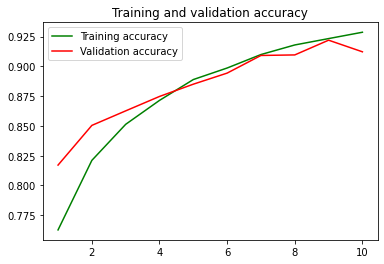

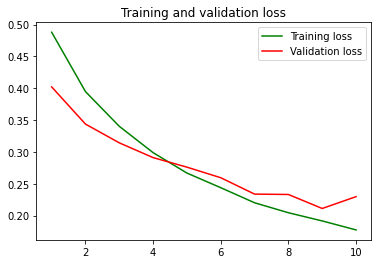

In [46]:
# Plot results
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Stance Detection

For Stance Detection the model we have used is from the [Udacity course](https://mathalope.co.uk/2015/04/23/udacity-programming-fundamentals-with-python-check-profanity/) Programming Foundation with python which is a profanity editor. We finetune it accordingly to use in our project approach.
So this is the [link](http://www.wdylike.appspot.com/?q=) that Udacity has made to give a true or false reading if you put in profanity at the end of the link. Model is available online via a link to be used directly.

Profanity meaning is a swear word.

As in sarcastic comments we sometimes see swear words are also been used that is why we considered it to use as a stance detection with our sarcasm detection model so that we can get to know if the sarcastic text is **positive**[Top level sarcastic], **negative**[Medium level sarcastic] or **neutral**[Low level sarcastic] when our sarcasm detection model detects sarcasm.

In [69]:
import urllib
import urllib.request 

def StanceDetection(text_to_check):

  url_string = "http://www.wdylike.appspot.com/?q=/links"
  new_url = url_string.replace("/links", text_to_check)
  connection = urllib.request.urlopen(new_url)
  output = connection.read()
  #print(output)
  connection.close()
  if output == 'true':
    print("\U0001f608 Positive")
  elif output == 'false':
    print("\U0001f615 Negative")
  else:
    print("\U0001f610 Neutral")

def Sarcasm_meter():

  quotes = open("myfile.txt")
  lines = quotes.readlines()
  for line in lines:
    #print(line)
    #print(line.replace(' ', '_'))
    a = line.replace(' ', '_')
  StanceDetection(a)

#Sarcasm_meter()

In [70]:
def Sarcasm_Detection(s):
    x_final = pd.DataFrame({"headline":[s]})
    test_lines = CleanTokenize(x_final)
    test_sequences = tokenizer_obj.texts_to_sequences(test_lines)
    test_review_pad = pad_sequences(test_sequences, maxlen=max_length, padding='post')
    pred = model.predict(test_review_pad)
    pred*=100
    if pred[0][0]>=50:
       #print(pred)
       print("Text is sarcastic!")
       Sarcasm_meter()
    else:
       print("Text is not sarcastic!")
       #Sarcasm_meter(Text)

In [60]:
file1 = open("myfile.txt","w")

b= input("Enter your Text here: ")
file1.write(b)
file1 = open("myfile.txt","r+")
Text = file1.read()

Sarcasm_Detection(Text)


Enter your Text here: How much you fuck with your shit?
Text is sarcastic!
😈 Positive


In [68]:
file1 = open("myfile.txt","w")

b= input("Enter your Text here: ")
file1.write(b)
file1 = open("myfile.txt","r+")
Text = file1.read()

Sarcasm_Detection(Text)

Enter your Text here: You son of potato
Text is sarcastic!
😕 Negative


In [77]:
file1 = open("myfile.txt","w")

b= input("Enter your Text here: ")
file1.write(b)
file1 = open("myfile.txt","r+")
Text = file1.read()

Sarcasm_Detection(Text)

Enter your Text here: You look like sponge bob square without pants 
Text is sarcastic!
😐 Neutral


In [63]:
file1 = open("myfile.txt","w")

b= input("Enter your Text here: ")
file1.write(b)
file1 = open("myfile.txt","r+")
Text = file1.read()

Sarcasm_Detection(Text)

Enter your Text here: I love NLP
Text is not sarcastic!


This project work help us in cementing and gaining the deep knowledge of NLP  and its concepts

# Thank you!